In [32]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
train_data = pd.read_csv('Project2_Train.csv')
test_data = pd.read_csv('Project2_Test.csv')
test_data = test_data.rename({'Damage': 'VehicleDamage'}, axis=1)

In [7]:
def preprocess(data, oneHotEncodedCategories, drop_mystery):
    return_data = data.copy()
    for cat in oneHotEncodedCategories:
        encoder = OneHotEncoder()
        encoder_df = pd.DataFrame(encoder.fit_transform(return_data[[cat]]).toarray())
        encoder_df.columns = [cat + " " + name.split('_', 1)[1] for name in encoder.get_feature_names()]
        return_data = return_data.join(encoder_df)
        return_data.drop(cat, axis = 1, inplace = True)
    if drop_mystery:
        return_data.drop('Mystery', axis = 1, inplace = True)
    return return_data

In [8]:
# Part 1
X_train_before = train_data[['Gender', 'Age', 'Region_Code', 'Age.1', 'VehicleDamage', 'Premium', 'Vintage', 'Mystery']]
y_train = train_data['Response']
X_test_before = test_data[['Gender', 'Age', 'Region_Code', 'Age.1', 'VehicleDamage', 'Premium', 'Vintage', 'Mystery']]
y_test = test_data['Response']

X_train = preprocess(X_train_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'], True)
X_test = preprocess(X_test_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'], True)

In [9]:
def train_one_model(estimator, param_grid, X_train = X_train, y_train = y_train):
    grid_rf_class = GridSearchCV(
        estimator = estimator,
        param_grid = param_grid,
        scoring = 'roc_auc',
        n_jobs = -4,
        cv = StratifiedKFold(random_state = 99, shuffle = True),
        refit = True,
        return_train_score = True
    )
    
    grid_rf_class.fit(X_train, y_train)

    return grid_rf_class

In [12]:
estimator_names = ["Logistic Regression", "Decision Tree", "Bagging Classifier","AdaBoost Classifier", "Gradient Boost"]
estimators = [LogisticRegression(), 
              DecisionTreeClassifier(), 
              BaggingClassifier(n_jobs = -4), 
              AdaBoostClassifier(), 
              GradientBoostingClassifier()]

grids = []

param_grids = [{}, 
               {
                   'max_depth': range(2, 5, 1),
                   'min_samples_leaf': np.linspace(0.01, 0.3, 10),
                   'max_leaf_nodes': range(2, 8, 1)
               },
               {
                   'max_samples': np.linspace(0.1, 1.0, 5),
                   'n_estimators': range(10, 60, 5),
                   'base_estimator': [DecisionTreeClassifier(max_depth = i) for i in range(2, 5, 1)]
               },
               {
                   'learning_rate': np.linspace(0.01, 0.2, 5),
                   'n_estimators': range(10, 60, 5),
                   'base_estimator': [DecisionTreeClassifier(max_depth = i) for i in range(2, 5, 1)]
               },
               {
                   'learning_rate': np.linspace(0.01, 0.2, 5),
                   'n_estimators': range(10, 60, 5),
                   'max_depth': range(2, 5, 1)
               }
              ]

for i in range(0, len(estimators)):
    print('--------------------------')
    
    grid_rf_class = train_one_model(estimators[i], param_grids[i])
    grids.append(grid_rf_class)
    
    print(estimator_names[i] + ' Done')
    print('best cv score: ' + str(grid_rf_class.best_score_))
    print('best params: ' + str(grid_rf_class.best_params_))
    
    print('--------------------------')

--------------------------
Logistic Regression Done
best cv score: 0.6121391288652074
best params: {}
--------------------------
--------------------------
Decision Tree Done
best cv score: 0.8180951328009384
best params: {'max_depth': 3, 'max_leaf_nodes': 7, 'min_samples_leaf': 0.07444444444444444}
--------------------------
--------------------------
Bagging Classifier Done
best cv score: 0.8262538691414774
best params: {'base_estimator': DecisionTreeClassifier(max_depth=4), 'max_samples': 1.0, 'n_estimators': 30}
--------------------------
--------------------------
AdaBoost Classifier Done
best cv score: 0.8239766268265557
best params: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.0575, 'n_estimators': 45}
--------------------------
--------------------------
Gradient Boost Done
best cv score: 0.826635508966946
best params: {'learning_rate': 0.105, 'max_depth': 3, 'n_estimators': 40}
--------------------------


In [13]:
# This is just used to save models
import joblib
import pickle

for i in range(0, len(estimators)):
    filename = estimator_names[i] + ".joblib"
    joblib.dump(grids[i], filename)

In [67]:
# This is just to regenerate GridSearchCV results without retraining them
import joblib
import pickle

grids = []

for i in range(0, len(estimators)):
    filename = estimator_names[i] + ".joblib"
    loaded_model = joblib.load(filename)
    grids.append(loaded_model)

In [74]:
disp = {}

for i in range(len(grids)):
    disp[estimator_names[i]] = {
        'Best Avg CV Score (AUC)': grids[i].best_score_,
        'Refit Time': grids[i].refit_time_
    }
    
df = pd.DataFrame(data=disp).T

df

,Best Avg CV Score (AUC),Refit Time
Logistic Regression,0.612139,0.049467
Decision Tree,0.818095,0.013166
Bagging Classifier,0.826254,0.237267
AdaBoost Classifier,0.823977,0.305334
Gradient Boost,0.826636,0.296937


In [15]:
dt_grid = grids[1]
dt = dt_grid.best_estimator_

print('best parameters: ', dt_grid.best_params_)

best parameters:  {'max_depth': 3, 'max_leaf_nodes': 7, 'min_samples_leaf': 0.07444444444444444}


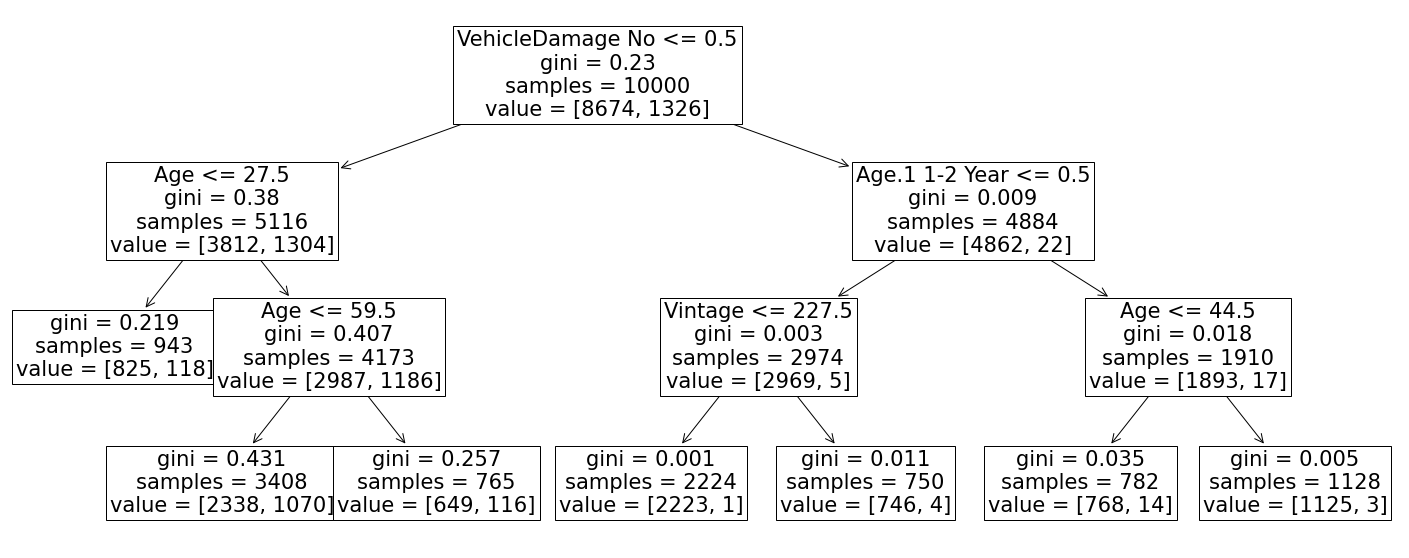

In [16]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dt, 
                   feature_names=X_train.columns,
                   fontsize = 21)

In [17]:
def combine_one_hot_encoded_covariates_importances(columns, importances, one_hot_encoded_vars):
    vars_substr = [x[0:5] for x in one_hot_encoded_vars]
    new_col_importances = {}
    for i, column in enumerate(columns):
        if column[0:5] in vars_substr:
            if column.split(' ')[0] not in new_col_importances:
                new_col_importances[column.split(' ')[0]] = importances[i]
            else:
                new_col_importances[column.split(' ')[0]] += importances[i]
        else:
            new_col_importances[column] = importances[i]
    return [list(new_col_importances.keys()), list(new_col_importances.values())]

In [58]:
def addlabels(x,y):
    props = dict(boxstyle='round', edgecolor='red', facecolor='None')
    for i in range(len(x)):
        plt.text(i, y[i] + 0.01, f'{y[i]:.4f}', ha = 'center', bbox = props if x[i] == 'Mystery' else None)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

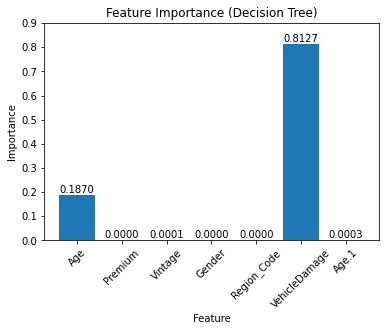

In [38]:
importances = dt.feature_importances_
columns = X_train.columns

columns, importances = combine_one_hot_encoded_covariates_importances(columns, 
                                                                      importances, 
                                                                      ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'])

plt.bar(columns, importances)
addlabels(columns, importances)
plt.ylim([0, 0.9])

plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Feature')
plt.ylabel('Importance')
    
plt.xticks(rotation=45)

In [39]:
auc_cv = dt_grid.best_score_
y_pred = dt.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_pred)

print("CV AUC Score: ", auc_cv)
print("Test AUC Score: ", auc_test)

CV AUC Score:  0.8180951328009384
Test AUC Score:  0.8131651808089713


In [40]:
# Part 2
X_train_before = train_data[['Gender', 'Age', 'Region_Code', 'Age.1', 'VehicleDamage', 'Premium', 'Vintage', 'Mystery']]
y_train = train_data['Response']
X_test_before = test_data[['Gender', 'Age', 'Region_Code', 'Age.1', 'VehicleDamage', 'Premium', 'Vintage', 'Mystery']]
y_test = test_data['Response']

X_train_dummy = preprocess(X_train_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1', 'Mystery'], False)
X_test_dummy = preprocess(X_test_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1', 'Mystery'], False)

categories = ['M' + str(x) for x in range(1, 21)]
enc = OrdinalEncoder(categories=[categories])

X_train_int = preprocess(X_train_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'], False)
X_train_int[["Mystery"]] = enc.fit_transform(X_train_int[["Mystery"]])

X_test_int = preprocess(X_test_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'], False)
X_test_int[["Mystery"]] = enc.fit_transform(X_test_int[["Mystery"]])

In [41]:
rf = RandomForestClassifier(random_state = 99)
params = {
    'max_samples': np.linspace(0.1, 1.0, 5),
    'n_estimators': range(10, 60, 5),
    'max_depth': range(2, 5, 1)
}

rf_grid_dummy = train_one_model(rf, params, X_train_dummy, y_train)
rf_grid_int = train_one_model(rf, params, X_train_int, y_train)

In [42]:
columns_dummy = X_train_dummy.columns
columns_int = X_train_int.columns

dummy_importances = rf_grid_dummy.best_estimator_.feature_importances_
int_importances = rf_grid_int.best_estimator_.feature_importances_

columns_dummy, dummy_importances = combine_one_hot_encoded_covariates_importances(columns_dummy, 
                                                          dummy_importances, 
                                                          ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1', 'Mystery'])

columns_int, int_importances = combine_one_hot_encoded_covariates_importances(columns_int, 
                                                          int_importances, 
                                                          ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'])

Importance of Mystery 0.022674441408714094


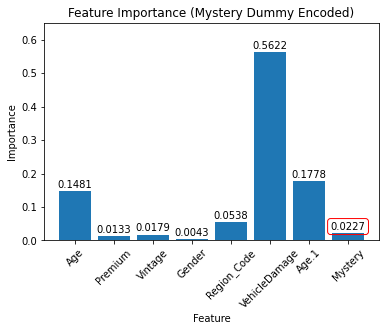

In [59]:
plt.bar(columns_dummy, dummy_importances)

addlabels(columns_dummy, dummy_importances)
plt.ylim([0, 0.65])

plt.title('Feature Importance (Mystery Dummy Encoded)')
plt.xlabel('Feature')
plt.ylabel('Importance')
    
plt.xticks(rotation=45)

i = columns_dummy.index('Mystery')
print('Importance of Mystery', dummy_importances[i])

Importance of Mystery 0.006808317552415448


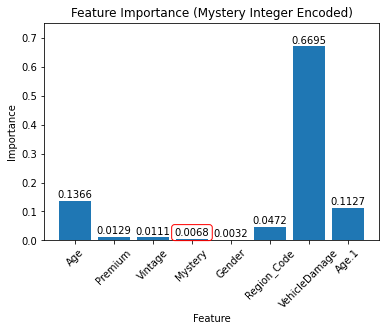

In [60]:
plt.bar(columns_int, int_importances)
addlabels(columns_int, int_importances)
plt.ylim([0, 0.75])

plt.title('Feature Importance (Mystery Integer Encoded)')
plt.xlabel('Feature')
plt.ylabel('Importance')
    
plt.xticks(rotation=45)

i = columns_int.index('Mystery')
print('Importance of Mystery', int_importances[i])

In [49]:
def convert_to_benefit(y_pred, y_actual, promote_interested, miss_interested, promote_uninterested, promotion):
    if y_pred == 1 and y_actual == 1:
        return promote_interested + promotion
    elif y_pred == 1 and y_actual == 0:
        return promote_uninterested + promotion
    elif y_pred == 0 and y_actual == 0:
        return 0
    elif y_pred == 0 and y_actual == 1:
        return miss_interested

In [50]:
# Discussion 2
y_prob = dt.predict_proba(X_train)[:, 1]

thresholds = [0.01, 0.1, 0.2, 0.5]
benefits = []

for threshold in thresholds:
    y_pred = [1 if y > threshold else 0 for y in y_prob]
    y_pred_actual = zip(y_pred, y_train)
    benefit = [convert_to_benefit(pred_actual[0], pred_actual[1], 10, -10, -2, -1) for pred_actual in y_pred_actual]
    benefits.append(sum(benefit))

print('thresholds', thresholds)
print('benefits', benefits)

thresholds [0.01, 0.1, 0.2, 0.5]
benefits [-1958, 80, 56, -13260]


In [51]:
# Discussion 3
y_prob = dt.predict_proba(X_train)[:, 1]

thresholds = [0.01, 0.1, 0.2, 0.5]
benefits = []

for threshold in thresholds:
    y_pred = [1 if y > threshold else 0 for y in y_prob]
    y_pred_actual = zip(y_pred, y_train)
    benefit = [convert_to_benefit(pred_actual[0], pred_actual[1], 100, -100, -2, -1) for pred_actual in y_pred_actual]
    benefits.append(sum(benefit))

print('thresholds', thresholds)
print('benefits', benefits)

thresholds [0.01, 0.1, 0.2, 0.5]
benefits [115942, 115460, 73316, -132600]
